In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
useful_crimes = gpd.read_file('filtered dataset/crimes_filtered.shp')
useful_crimes.to_crs('EPSG:4326', inplace=True)

In [4]:
manz = gpd.read_file('nyct2020_23b/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


<Axes: >

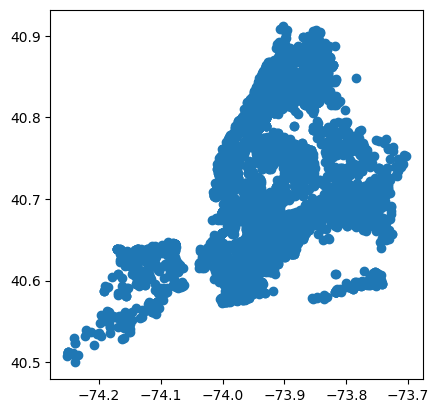

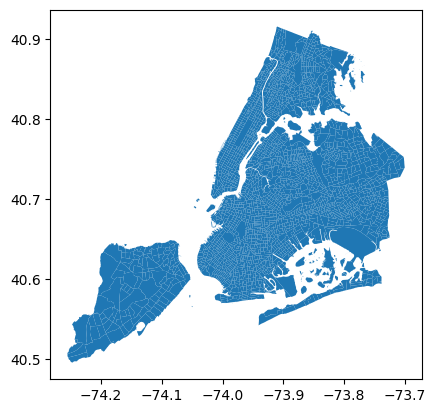

In [5]:
useful_crimes.plot()
manz.plot()

In [6]:
useful_crimes.head(1)

,cmplnt_num,addr_pct_c,boro_nm,date_cmpln,time_cmpln,cmplnt_fr_,date_cmp_2,time_cmp_2,cmplnt_to_,crm_atpt_c,...,susp_sex,transit_di,vic_age_gr,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,geometry
0,262612530,110.0,QUEENS,2022-09-09,00:00:00.000,00:55:00,2022-09-09,00:00:00.000,01:19:00,COMPLETED,...,M,NaN,25-44,WHITE HISPANIC,F,1019164.0,210169.0,40.743481,-73.874004,POINT (-73.87400 40.74348)


### 1. Importaciones y preprocesamiento

<Axes: >

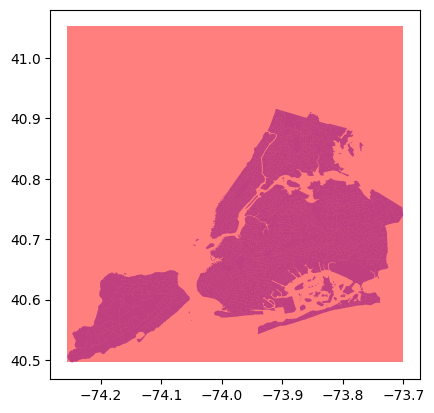

In [7]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [8]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]

In [9]:
aoi2 = ee.Geometry.Point([x-1, y-1])

In [39]:
# "LANDSAT/LE07/C01/T1"
collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi2).filterDate('2023-01-30', '2023-06-22')
images=collection.aggregate_array('system:id').getInfo()

In [40]:
len(images)

7

In [51]:
Map = geemap.Map()
least_cloudy = ee.Image(collection.sort('CLOUDY_PIXEL_PERCENTAGE').first())
vis_params = {'min': 0,  # Minimum temperature in Kelvin (e.g., 0°C)
    'max': 65535,  # Maximum temperature in Kelvin (e.g., 40°C)
    'bands': 'ST_B10'}

clipped_image = least_cloudy.clip(aoi)
Map.addLayer(clipped_image, vis_params, 'prueba')

In [52]:
Map.centerObject(aoi2, 12)

In [53]:
Map

Map(center=[39.773871012612915, -74.97780021318201], controls=(WidgetControl(options=['position', 'transparent…